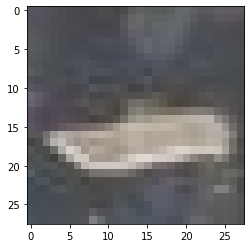

In [1]:
import os
os.chdir('../')
# 导入 opencv-python
import cv2

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    """opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    """输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    
show_img_from_path('../../data/imgs/u4e00_000000.jpg')

In [2]:
from mmcv import Config
from mmdet.apis import set_random_seed

cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_stone_dataset.py')

# 存放输出结果和日志的目录
cfg.work_dir = './demo/recog'

# 初始学习率 0.001 是针对 8 个 GPU 训练的
# 如果只有一个 GPU，则除以8
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None

# 每训练40张图像，记录一次日志
cfg.log_config.interval = 40

# 设置随机数种子
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(cfg.pretty_text)

checkpoint_config = dict(interval=1)
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='

In [3]:
import mmcv
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

# 建立数据集
datasets = [build_dataset(cfg.data.train)]

# 建立模型
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# 创建新目录，保存训练结果
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/featurize/work/mmocr/mmocr/datasets/utils/loader.py:86: UserWarning: HardDiskLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)


In [4]:
from mmocr.apis import init_detector, model_inference
# 指定模型 checkpoint 权重文件
checkpoint = "./demo/tutorial_exps/epoch_5.pth"


model = init_detector(cfg, checkpoint, device="cuda:0")

load checkpoint from local path: ./demo/tutorial_exps/epoch_5.pth


/home/featurize/work/mmocr/mmocr/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


不


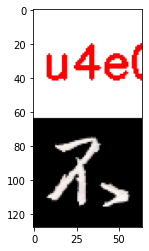

In [14]:
# 指定待测图像路径
# input_path = '../../data/imgs/u4e00_000058.jpg'
input_path = './demo/input/1 (440).jpg'
result = model_inference(model, input_path)
bs = '\\'+result['text']
print(bs.encode('utf-8').decode('unicode_escape'))
out_img = model.show_result(input_path, result, out_file='outputs/demo-out.jpg', show=False)
show_img_from_array(out_img)